In [1]:
import tensorflow as tf
import tqdm
import numpy as np
import scipy.io
# specify the dimensions of the dataset
DATA_HEIGHT = 192
DATA_WIDTH = 64
DATA_DEPTH = 64

2023-01-23 15:10:35.920994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 15:10:36.128775: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Generator

Define the generator model. The generator is a modified U-Net composed of an encoder, and decoder.

1. The **encoder** function is composed of **convolution**, **batch normalization**, and **LeakyReLU** layers.
    - **Convolution** layers are used to extract features from the input image by applying a set of filters to the image. These filters are learned during the training process and are able to extract useful information from the image such as edges, textures, and patterns.
    - **Batch normalization** is used to normalize the activations of the convolution layers. It helps to stabilize the training process by reducing internal covariate shift, which is the change in the distribution of the inputs to a layer. This can improve the performance of the model.
        - batch normalization is not applied to the first layer of the downsampler in the generator of a GAN because the input to the first layer is noise, which has a different distribution than the real data. 
    - **LeakyReLU** is a type of activation function that is used to introduce non-linearity in the model. ReLU (Rectified Linear Unit) is one of the most used activation functions, but it can lead to the problem of dying ReLU, which is when a neuron stops outputting anything other than zero. LeakyReLU is a variant of ReLU that allows a small, non-zero gradient when the input is negative, which can help to prevent the dying ReLU problem.
    - Together, these layers work well to extract useful features from the input image, reduce the spatial dimensions of the image, and introduce non-linearity in the model, which are the key operations in an encoder or downsampler models.<br><br>
    
2. The **decoder** is composed of **transposed convolution**, **batch normalization**, **dropuout**, and **ReLU** layers.
    - A **Dropout** layer is often used in decoder or upsampler models to reduce overfitting. Dropout is a regularization technique that helps to prevent overfitting by randomly dropping out (setting to zero) a certain percentage of the neurons during training. When training a decoder or upsampler model, the model is trying to learn the mapping from a lower-dimensional representation to a higher-dimensional one. During this process, some neurons can become very important to the model, and the model can become too dependent on them. This can lead to overfitting, where the model is too specialized to the training data and performs poorly on unseen data. Dropout can help to prevent this by randomly dropping out neurons during training, forcing the model to learn more robust features and not to become too dependent on any particular neuron. This can help to improve the generalization ability of the model, making it perform better on unseen data.
    
It is important to note that leaky ReLU is typically used in the encoder because it helps to alleviate the problem of the "vanishing gradient" and it helps to speed up the training process, while ReLU is typically used in the decoder because it helps to ensure that the output generated is non-negative.

3. There are skip connections between the encoder and decoder (as in the U-Net), which allow the spatial information from the encoder to be passed directly to the decoder.

2023-01-23 15:10:40.440608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 15:10:46.671355: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24459 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-01-23 15:10:46.672904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1037 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2023-01-23 15:10:46.674945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localh

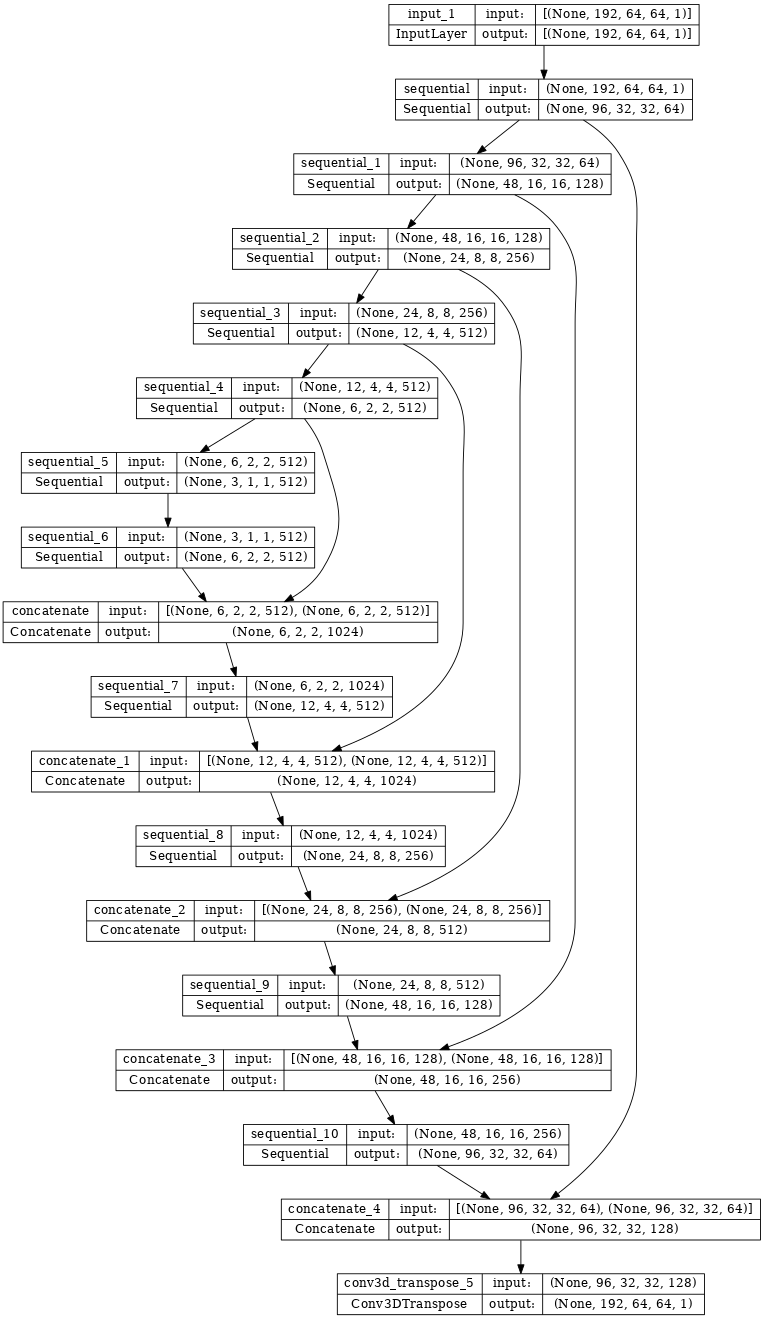

In [2]:
# encoder block
def encoder(num_filters,filt_size,apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0,0.02)
    kernel = tf.keras.Sequential()
    kernel.add(tf.keras.layers.Conv3D(num_filters,
                                      filt_size,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    if apply_batch_norm:
        kernel.add(tf.keras.layers.BatchNormalization())
    kernel.add(tf.keras.layers.LeakyReLU())
    return kernel

# decoder block
def decoder(num_filters,filt_size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0,0.02)
    kernel = tf.keras.Sequential()
    kernel.add(tf.keras.layers.Conv3DTranspose(num_filters,
                                               filt_size,
                                               strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))
    kernel.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        kernel.add(tf.keras.layers.Dropout(0.5))
    kernel.add(tf.keras.layers.ReLU())
    return kernel

# generator
def generator(OUTPUT_CHANNELS=1):
    inputs = tf.keras.layers.Input(shape=[DATA_HEIGHT,DATA_WIDTH,DATA_DEPTH,1])
    # encoder
    encoders_stack = [encoder(64,4,apply_batch_norm=False),
                      encoder(128,4),
                      encoder(256,4),
                      encoder(512,4),
                      encoder(512,4),
                      encoder(512,4)]
    # decoder
    decoders_stack = [decoder(512,4,apply_dropout=True),
                      decoder(512,4,apply_dropout=True),
                      decoder(256,4),
                      decoder(128,4),
                      decoder(64,4)]
    last = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                           4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=tf.random_normal_initializer(0,0.02),
                                           use_bias=False,
                                           activation='linear')
    # implement the generator using skip connections between encoder and decoder
    x = inputs
    skips=[]
    for encoder_block in encoders_stack:
        x = encoder_block(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for decoder_block,skip in zip(decoders_stack,skips):
        x = decoder_block(x)
        x = tf.keras.layers.Concatenate()([x,skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs,outputs=x)
generator = generator()
tf.keras.utils.plot_model(generator,show_shapes=True,dpi=64)

## Discriminator

Define the **discriminator** model. The discriminator is a convolutional **PatchGAN** classifier. The PatchGAN classifier is a variant of the discriminator network in which it classifies image patches rather than the entire image. This allows for a more detailed and fine-grained control over the generated images, as different parts of the image can be generated with different levels of realism. 

1. Each block of the **discriminator** is composed of convolution, batch normalization, and Leaky ReLU layers.
    - **Convolutional** layers are used in the discriminator to extract features from the input images, such as edges, textures, and shapes. These features are then passed through **batch normalization** layers, which standardize the distribution of the inputs to the next layers, making the training process more stable and efficient.
        - batch normalization is not applied to the first block.
    - **Leaky ReLU** is used as the activation function in the discriminator as it allows for small gradient flow during the negative part of the input, preventing the dying ReLU problem, which occurs when the ReLU neurons are stuck in the inactive state.
2. The **discriminator** receives two inputs:
    - The input image and the target image, which it should classify as real.
        - The input image is obtained by CT and the target image is obtained by PC-MRI.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
        - The input image is obtained by CT and the generated image is obtained by generator.
    - Concatenate the two inputs together.

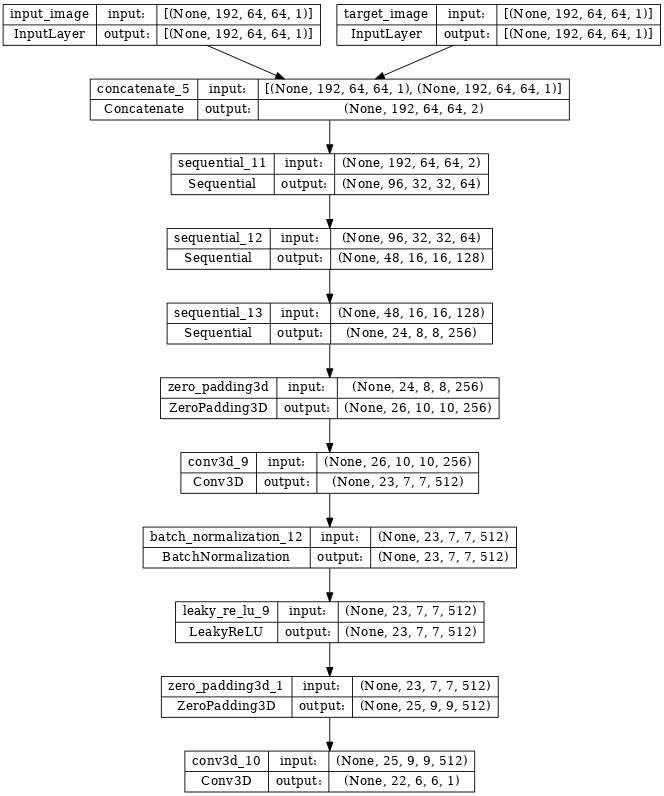

In [3]:
# encoder block
def encoder(num_filters,filt_size,apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0,0.02)
    kernel = tf.keras.Sequential()
    kernel.add(tf.keras.layers.Conv3D(num_filters,
                                      filt_size,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    if apply_batch_norm:
        kernel.add(tf.keras.layers.BatchNormalization())
    kernel.add(tf.keras.layers.LeakyReLU())
    return kernel

# discriminator
def discriminator():
    initializer = tf.random_normal_initializer(0.0,0.02)
    inp = tf.keras.layers.Input(shape=[DATA_HEIGHT,DATA_WIDTH,DATA_DEPTH,1],
                                name='input_image')
    tar = tf.keras.layers.Input(shape=[DATA_HEIGHT,DATA_WIDTH,DATA_DEPTH,1],
                                name='target_image')
    x = tf.keras.layers.concatenate([inp,tar])
    down1 = encoder(64,4,False)(x)
    down2 = encoder(128,4)(down1)
    down3 = encoder(256,4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding3D()(down3) 
    conv = tf.keras.layers.Conv3D(512,
                                  4,
                                  strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)
    batchnorm = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm)
    zero_pad2 = tf.keras.layers.ZeroPadding3D()(leaky_relu)
    last = tf.keras.layers.Conv3D(1,
                                  4,
                                  strides=1,
                                  kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp,tar],outputs=last)
discriminator = discriminator()
tf.keras.utils.plot_model(discriminator,show_shapes=True,dpi=64)

## Generator Loss Function

The generator's loss is a measure of how well it is able to produce images that are similar to the real images from the dataset, given a certain condition. The generator's loss is typically a combination of two different loss functions: the adversarial loss and the conditional loss.

1. **Adversarial loss**: The adversarial loss is used to train the generator to produce images that are able to foool the discriminator. The generator's goal is to minimize this loss by producing images that the discriminator is unable to distinguish from real images. This loss is calculated using the output of the discriminator, which is a probability that the input image is real. 
    - The adversarial loss is calculated as the binary cross-entropy between an all-ones tensor and the discriminator output.
    - Binary cross-entropy loss (also known as log loss) is a commonly used loss function for binary classification problems. It measures the dissimilarity between the predicted probability distribution and the true distribution of the binary outcome. In other words, it measures how well the predicted probability of an outcome (e.g. 0 or 1) aligns with the true outcome.
        - The binary cross-entropy loss function is defined as:
        - loss = -(y * log(p) + (1-y) * log(1-p))
            - y is the true binary outcome (0 or 1).
            - p is the predicted probabiliy of the positive class (i.e., probability of y = 1).
            - If the predicted probability is close to 1 when the true outcome is 1 and close to 0 when the true outcome is 0, the loss will be small, indicating that the model is performing well. Conversely, if the predicted probability is far from the true outcome, the loss will be large, indicating that the model is performing poorly.
            -  The "from_logits" parameter controls whether the loss function expects the input to be the predicted probability or the logits.
            - In the case of logits, logits are the raw output from the last layer of a neural network before the activation function is applied. Logits are often used in the calculation of loss functions because they are a convenient intermediate value to use. The logits are usually passed through an activation function, such as the sigmoid function, to obtain the predicted probability.
2. **Conditional loss**: The conditional loss is used to ensure that the generator produces images that are conditioned on a certain variable. This loss is calculated by comparing the conditioning variable that the generator receives as input with the conditioning variable that is associated with the real image. 
3. The generator's total loss is usually the sum of these two losses, which is calculated as:
    - loss = adversarial_loss - lambda * conditional_loss
    - Where lambda is a scalar hyperparameter that controls the weight of the conditional loss in the total loss. The generator is trained to minimize this total loss.

In [11]:
# adversarial loss object
adv_loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# lambda
LAMBDA = 100
# generator loss
def generator_loss(discriminator_output, generator_output, target):
    # conditional loss
    cond_loss = tf.reduce_mean(tf.abs(generator_output,target))
    # adversarial loss
    adv_loss = adv_loss_obj(tf.ones_like(discriminator_output),
                            discriminator_output)
    # total loss
    total_generator_loss = adv_loss+(LAMBDA*cond_loss)
    return total_generator_loss, adv_loss, cond_loss

## Discriminator Loss Function

The discriminator's loss is typically the sum of the adversarial loss and the conditional loss. 
1. The **conditional loss** is a sigmoid cross-entropy loss of the target images and an array of ones(since these are the real images).
2. The **adversarial** loss is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).

In [23]:
# adversarial loss object
adv_loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# discriminator loss
def discriminator_loss(discriminator_output_real, discriminator_output_fake):
    # conditional loss
    cond_loss = adv_loss_obj(tf.ones_like(discriminator_output_real),
                             discriminator_output_real)
    # adversarial loss
    adv_loss = adv_loss_obj(tf.zeros_like(discriminator_output_fake),
                            discriminator_output_fake)
    # total loss
    total_discriminator_loss = adv_loss+cond_loss
    return total_discriminator_loss

## Define the optimizers

Both generator and discriminator optimizers are Adam (Adaptive Moment Estimation), which is a popular optimization algorithm for training neural networks. It is an extension of the stochastic gradient descent (SGD) algorithm that uses the idea of adaptive learning rates. Adam uses the gradient information from the past steps to adapt the learning rate for each parameter individually, which allows for faster convergence and better performance compared to the traditional SGD algorithm.

Here, there are two inputs specified for each optimizer:
1.  The initial learning rate. This is a scalar value that controls the step size in the optimization process. 
2. 'beta_1' which is the exponential decay rate for the first moment estimates. 

In [6]:
# generator optimizer
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# discriminator optimizer
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoint and sample saver

We use the "tf.train.Checkpoint" class to save and restore the state of model during training. 

In [33]:
# the directory to save the model outputs
output_dir = './pix2pix_output' 
# if the output directory does not exist, creates it
if not tf.io.gfile.isdir(output_dir):
    tf.io.gfile.mkdir(output_dir) 
# define the checkpoint directory
checkpoint_dir = tf.io.gfile.join(output_dir,'training_checkpoits') # where to save model ch
# if the checkpoint directory does not exist, creates it
if not tf.io.gfile.isdir(checkpoint_dir):
    tf.io.gfile.mkdir(checkpoint_dir) 
checkpoint_prefix = tf.io.gfile.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discrimnator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)
# directory to save example results during the training
sample_dir = tf.io.gfile.join(output_dir,'samples_training') 
if not tf.io.gfile.isdir(sample_dir):
    tf.io.gfile.mkdir(sample_dir)

## Training step

We use the **@tf.function** decorator to convert a Python function into a TensorFlow graph. This allows the function to be executed as a TensorFlow computation, which can be run on a GPU or TPU for faster performance.

When a Python function decorated with @tf.function is called, TensorFlow will trace the function and build a graph representation of the computation. This graph is then optimized and stored in a cache, so that subsequent calls to the function can be executed more quickly, without the overhead of tracing and building the graph again.

We use the tensorFlow's **tf.GradientTape** as a powerful tool for computing gradients of computations with respect to input variables. **tf.GradientTape** allows you to record the computations that are performed during the forward pass of a model, and then use this information to compute gradients during the backward pass.

We use the **apply_gradients** to update the variables of the model with the gradients computed during the backward pass. The optimizer takes a list of (gradient, variable) pairs and updates the variables with the gradients. It's important to note that the optimizer updates the variable in place, so the variable state is changed.

In [29]:
# training step
# @tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate an output on the input_image
        gen_output = generator(input_image,training=True)
        # find the discriminator output on the real input_image
        disc_real_output = discriminator([input_image,target],training=True)
        # find the discriminator output on the fake generator_generated image
        disc_generated_output = discriminator([input_image,gen_output],training=True)
        # calculate the generator loss
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,
                                                                   gen_output, 
                                                                   target)
        # calculate the discriminator loss
        disc_loss = discriminator_loss(disc_real_output, 
                                       disc_generated_output)
        # calculate the generator gradients
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)
        # calculate the discriminator gradients
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                     discriminator.trainable_variables)
        # update the generator model
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                                generator.trainable_variables))
        # update the discriminator model
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                    discriminator.trainable_variables))

## Load the dataset

The dataset are created in**TFRecord** format, which is a binary file format used to store data in TensorFlow. It is a widely used format to store large datasets efficiently. A TFRecord file contains a sequence of records, where each record is a binary serialization of a data example. This format is more efficient than storing data in plain text format (e.g. CSV) because it is more compact and can be read more quickly by TensorFlow.

We define a **parser** function,which is a function that reads a TFRecord file and extracts the data from it in a format that can be used by TensorFlow. The parser function is responsible for deserializing the binary data in the TFRecord file and converting it into a format that can be used as input to a TensorFlow model.

In [25]:
# define a function to crop the datasests to a desired size around the center
@tf.function
def center_crop(image,size):
    if not isinstance(size, (tuple,list)):
        size = [size, size]
    offset_height = (tf.shape(image)[-3]-size[0])//2
    offset_width = (tf.shape(image)[-2]-size[1])//2
    return tf.image.crop_to_bounding_box(image,offset_height,offset_width,size[0],size[1])
# define a parser for tfrecords
def parser(tfrecord):
    feature = tf.io.parse_single_example(tfrecord,{'A': tf.io.FixedLenFeature(shape=[], dtype=tf.string),
              'B' : tf.io.FixedLenFeature(shape=[], dtype=tf.string),
              'height' : tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
              'width'  : tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
              'depth'  : tf.io.FixedLenFeature(shape=[], dtype=tf.int64)})
    height = tf.cast(feature["height"], tf.int32)
    width  = tf.cast(feature["width"], tf.int32)
    depth  = tf.cast(feature["depth"], tf.int32)
    A = tf.io.decode_raw(feature['A'], tf.float32) 
    A = tf.reshape(A, [height, width, depth])
    A = center_crop(A, [DATA_HEIGHT,DATA_WIDTH])
    B = tf.io.decode_raw(feature['B'], tf.float32) 
    B = tf.reshape(B, [height, width, depth])
    B = center_crop(B, [DATA_HEIGHT,DATA_WIDTH])
    return tf.expand_dims(A,axis=-1),tf.expand_dims(B,axis=-1)
# specify the path to the training set
tfrecord_path = 'anatomay2flow_train_pix2pix.tfrecords' 
dataset_train = tf.data.TFRecordDataset(tfrecord_path)
# return the size of the training set
DATA_SIZE = len(list(dataset_train)) 
BUFFER_SIZE = DATA_SIZE
dataset_train = dataset_train.map(map_func=parser,num_parallel_calls=tf.data.AUTOTUNE)
dataset_train = dataset_train.shuffle(buffer_size=BUFFER_SIZE)
BATCH_SIZE = 1
dataset_train = dataset_train.batch(BATCH_SIZE)
# create a set of test samples
tfrecord_path = 'anatomay2flow_test_pix2pix.tfrecords'
dataset_test = tf.data.TFRecordDataset(tfrecord_path)
dataset_test = dataset_test.map(map_func=parser,num_parallel_calls=tf.data.AUTOTUNE)
dataset_test = dataset_test.batch(BATCH_SIZE)
dataset_test = iter(dataset_test)
# save ten samples in the test to monitor the model performance as it is being trained
Asample = list()
Bsample = list()
ii = 1
for a,b in dataset_test:
    Asample.append(a)
    Bsample.append(b)
    ii+=1
    if ii>10:
        print(a.shape)
        break

(1, 192, 64, 64, 1)


## Train the model

To train the model, we begin by checking for available checkpoints in the designated checkpoints directory, in order to continue training from the last available epoch. As training progresses, new checkpoints are generated after each completed epoch. Furthermore, after each epoch, the model's performance is evaluated by running it on five separate test sets, and the results are recorded.

**tqdm.trange()** is a function provided by the **tqdm** library in Python. It is used to create a progress bar for loops that iterate over a range of numbers. The **trange()** function is similar to the built-in **range()** function in Python, but it also displays a progress bar that shows the progress of the loop.

In [37]:
# specifiy number of epochs to train the network
epochs = 10
# Restoring the latest checkpoint in checkpoint_dir
checkpoint_address = tf.train.latest_checkpoint(checkpoint_dir) # returns the address of last checkpoint
epochs_so_far = 0 
# verifies if the checkpoint exists
if checkpoint_address: 
    # restores to the last checkpoint
    checkpoint.restore(checkpoint_address) 
    # finds the location of hyphen in the checkpoint address
    hyphen = checkpoint_address.index('-') 
    # finds the number trained epochs
    epochs_so_far = int(checkpoint_address[hyphen+1:]) 
    print("Restored the model from epoch {}".format(epochs_so_far))
# train the model
for epoch in tqdm.trange(epochs_so_far+1,epochs+epochs_so_far+1,desc="Outer Epoch",total=epochs):
    for anatomy,flow in tqdm.tqdm(dataset_train,desc="Inner Epoch",total=DATA_SIZE):
        train_step(anatomy,flow)
    # save a checkpoint after each epoch
    checkpoint.save(checkpoint_prefix)
    ii = 0
    for A, B in zip(Asample,Bsample):
        # return the anatomy data
        anatomy = tf.squeeze(A.numpy())
        # return the flow data
        flow = tf.squeeze(B.numpy())
        # convert anatomy to flow using the trained generator
        A2B = generator(A,training=True)
        anatomy2flow = tf.squeeze(A2B.numpy())  
        # create a file name based on the epoch number
        filename1 = tf.io.gfile.join(sample_dir,'iter-%03u-%02u.mat' % (epoch,ii))
        # save the data
        scipy.io.savemat(filename1,{'anatomy':anatomy.numpy(),
                        'flow':flow.numpy(),
                        'anatomy2flow':anatomy2flow.numpy()})
        ii+=1

Restored the model from epoch 1


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 11:43:36.721139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 827 of 909
2023-01-24 11:43:37.741571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.

Inner Epoch:  10%|██▉                          | 92/909 [00:34<03:24,  4.00it/s]


Inner Epoch:  21%|█████▊                      | 189/909 [00:58<02:58,  4.02it/s]


Inner Epoch:  31%|████████▊                   | 286/909 [01:27<04:46,  2.18it/s]


Inner Epoch:  42%|███████████▊                | 383/909 [02:05<03:59,  2.19it/s]


Inner Epoch:  53%|██████████████▊             | 480/909 [02:42<03:17,  2.18it/s]


Inner Epoch:  63%|█████████████████▊          | 577/909 [03:19<02:28,  2.23it/s]


Inner Epoch:  74%|████████████████████▊       | 674/909 [03:56<01:21,  2.88it/s]


Inner Epoch:  85%|███████████████████████▋    | 771/909 [04:33<01:02,  2.21it/s]


Inner Epoch:  95%|██████████████████████████▋ | 868/909 [05:10<00:11,  3.62it/s]


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 11:49:21.723280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 672 of 909
2023-01-24 11:49:24.655821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.

Inner Epoch:   6%|█▋                           | 51/909 [00:32<06:37,  2.16it/s]


Inner Epoch:  16%|████▌                       | 148/909 [01:09<03:42,  3.42it/s]


Inner Epoch:  27%|███████▌                    | 245/909 [01:46<05:05,  2.17it/s]


Inner Epoch:  38%|██████████▌                 | 342/909 [02:23<02:35,  3.64it/s]


Inner Epoch:  48%|█████████████▌              | 439/909 [03:00<02:11,  3.59it/s]


Inner Epoch:  59%|████████████████▌           | 536/909 [03:37<01:36,  3.85it/s]


Inner Epoch:  70%|███████████████████▍        | 633/909 [04:15<02:05,  2.20it/s]


Inner Epoch:  80%|██████████████████████▍     | 730/909 [04:51<01:17,  2.30it/s]


Inner Epoch:  91%|█████████████████████████▍  | 827/909 [05:29<00:36,  2.22it/s]


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 11:55:40.626099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 823 of 909
2023-01-24 11:55:41.597254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.

Inner Epoch:   1%|▎                            | 10/909 [00:13<06:16,  2.38it/s]


Inner Epoch:  12%|███▎                        | 107/909 [00:50<04:20,  3.07it/s]


Inner Epoch:  22%|██████▎                     | 204/909 [01:27<04:22,  2.68it/s]


Inner Epoch:  33%|█████████▎                  | 301/909 [02:05<04:29,  2.25it/s]


Inner Epoch:  44%|████████████▎               | 398/909 [02:42<03:52,  2.20it/s]


Inner Epoch:  54%|███████████████▏            | 495/909 [03:20<03:10,  2.18it/s]


Inner Epoch:  65%|██████████████████▏         | 592/909 [03:58<02:24,  2.19it/s]


Inner Epoch:  76%|█████████████████████▏      | 689/909 [04:35<01:41,  2.18it/s]


Inner Epoch:  86%|████████████████████████▏   | 786/909 [05:12<00:42,  2.87it/s]


Inner Epoch:  97%|███████████████████████████▏| 883/909 [05:49<00:12,  2.16it/s]


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 12:01:56.430924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 826 of 909
2023-01-24 12:01:57.555255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.

Inner Epoch:   7%|██                           | 66/909 [00:37<04:53,  2.87it/s]


Inner Epoch:  18%|█████                       | 163/909 [01:14<05:40,  2.19it/s]


Inner Epoch:  29%|████████                    | 260/909 [01:51<03:18,  3.27it/s]


Inner Epoch:  39%|██████████▉                 | 357/909 [02:28<04:18,  2.13it/s]


Inner Epoch:  50%|█████████████▉              | 454/909 [03:05<02:52,  2.63it/s]


Inner Epoch:  61%|████████████████▉           | 551/909 [03:42<02:23,  2.49it/s]


Inner Epoch:  71%|███████████████████▉        | 648/909 [04:19<01:38,  2.65it/s]


Inner Epoch:  82%|██████████████████████▉     | 745/909 [04:55<00:43,  3.74it/s]


Inner Epoch:  93%|█████████████████████████▉  | 842/909 [05:32<00:17,  3.80it/s]


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 12:08:12.402094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 765 of 909
2023-01-24 12:08:14.295864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.

Inner Epoch:   3%|▊                            | 25/909 [00:21<04:31,  3.26it/s]


Inner Epoch:  13%|███▊                        | 122/909 [00:58<06:04,  2.16it/s]


Inner Epoch:  24%|██████▋                     | 219/909 [01:35<04:31,  2.54it/s]


Inner Epoch:  35%|█████████▋                  | 316/909 [02:12<04:33,  2.16it/s]


Inner Epoch:  45%|████████████▋               | 413/909 [02:49<02:21,  3.50it/s]


Inner Epoch:  56%|███████████████▋            | 510/909 [03:26<02:26,  2.72it/s]


Inner Epoch:  67%|██████████████████▋         | 607/909 [04:02<01:26,  3.51it/s]


Inner Epoch:  77%|█████████████████████▋      | 704/909 [04:39<00:54,  3.75it/s]


Inner Epoch:  88%|████████████████████████▋   | 801/909 [05:16<00:30,  3.58it/s]


Inner Epoch:  99%|███████████████████████████▋| 898/909 [05:53<00:03,  2.91it/s]


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 12:14:28.733857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 795 of 909
2023-01-24 12:14:29.983521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.

Inner Epoch:   9%|██▌                          | 81/909 [00:43<04:07,  3.35it/s]


Inner Epoch:  20%|█████▍                      | 178/909 [01:19<03:15,  3.75it/s]


Inner Epoch:  30%|████████▍                   | 275/909 [01:56<03:00,  3.52it/s]


Inner Epoch:  41%|███████████▍                | 372/909 [02:33<02:18,  3.87it/s]


Inner Epoch:  52%|██████████████▍             | 469/909 [03:10<02:02,  3.60it/s]


Inner Epoch:  62%|█████████████████▍          | 566/909 [03:47<01:32,  3.70it/s]


Inner Epoch:  73%|████████████████████▍       | 663/909 [04:24<01:41,  2.43it/s]


Inner Epoch:  84%|███████████████████████▍    | 760/909 [05:01<01:01,  2.43it/s]


Inner Epoch:  94%|██████████████████████████▍ | 857/909 [05:39<00:23,  2.20it/s]


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 12:20:47.142959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 777 of 909
2023-01-24 12:20:49.046979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.

Inner Epoch:   4%|█▎                           | 40/909 [00:27<04:18,  3.37it/s]


Inner Epoch:  15%|████▏                       | 137/909 [01:04<03:45,  3.42it/s]


Inner Epoch:  26%|███████▏                    | 234/909 [01:41<03:05,  3.64it/s]


Inner Epoch:  36%|██████████▏                 | 331/909 [02:18<02:40,  3.59it/s]


Inner Epoch:  47%|█████████████▏              | 428/909 [02:55<02:11,  3.66it/s]


Inner Epoch:  58%|████████████████▏           | 525/909 [03:32<02:38,  2.42it/s]


Inner Epoch:  68%|███████████████████▏        | 622/909 [04:11<02:11,  2.17it/s]


Inner Epoch:  79%|██████████████████████▏     | 719/909 [04:48<01:26,  2.19it/s]


Inner Epoch:  90%|█████████████████████████▏  | 816/909 [05:25<00:42,  2.21it/s]


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 12:27:05.952817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 773 of 909
2023-01-24 12:27:07.745641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Inner Epoch:  11%|███                          | 97/909 [00:48<06:12,  2.18it/s]


Inner Epoch:  21%|█████▉                      | 194/909 [01:24<05:22,  2.22it/s]


Inner Epoch:  32%|████████▉                   | 291/909 [02:03<04:44,  2.17it/s]


Inner Epoch:  43%|███████████▉                | 388/909 [02:40<03:58,  2.18it/s]


Inner Epoch:  53%|██████████████▉             | 485/909 [03:18<03:14,  2.18it/s]


Inner Epoch:  64%|█████████████████▉          | 582/909 [03:55<01:42,  3.18it/s]


Inner Epoch:  75%|████████████████████▉       | 679/909 [04:32<01:10,  3.25it/s]


Inner Epoch:  85%|███████████████████████▉    | 776/909 [05:08<00:35,  3.79it/s]


Inner Epoch:  96%|██████████████████████████▉ | 873/909 [05:46<00:09,  3.79it/s]


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 12:33:24.660579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 749 of 909
2023-01-24 12:33:26.679246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.

Inner Epoch:   6%|█▊                           | 56/909 [00:33<05:23,  2.64it/s]


Inner Epoch:  17%|████▋                       | 153/909 [01:10<03:54,  3.22it/s]


Inner Epoch:  28%|███████▋                    | 250/909 [01:47<03:07,  3.52it/s]


Inner Epoch:  38%|██████████▋                 | 347/909 [02:24<02:45,  3.39it/s]


Inner Epoch:  49%|█████████████▋              | 444/909 [03:00<01:59,  3.90it/s]


Inner Epoch:  60%|████████████████▋           | 541/909 [03:38<01:40,  3.65it/s]


Inner Epoch:  70%|███████████████████▋        | 638/909 [04:15<01:50,  2.46it/s]


Inner Epoch:  81%|██████████████████████▋     | 735/909 [04:53<01:21,  2.13it/s]


Inner Epoch:  92%|█████████████████████████▋  | 832/909 [05:29<00:34,  2.21it/s]


Inner Epoch:   0%|                                      | 0/909 [00:00<?, ?it/s]2023-01-24 12:39:42.119266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 826 of 909
2023-01-24 12:39:43.188770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.

Inner Epoch:   2%|▍                            | 15/909 [00:15<04:33,  3.27it/s]


Inner Epoch:  12%|███▍                        | 112/909 [00:52<03:45,  3.53it/s]


Inner Epoch:  23%|██████▍                     | 209/909 [01:29<04:29,  2.60it/s]


Inner Epoch:  34%|█████████▍                  | 306/909 [02:06<04:23,  2.29it/s]


Inner Epoch:  44%|████████████▍               | 403/909 [02:45<03:50,  2.20it/s]


Inner Epoch:  55%|███████████████▍            | 500/909 [03:22<03:07,  2.18it/s]


Inner Epoch:  66%|██████████████████▍         | 597/909 [04:00<02:22,  2.19it/s]


Inner Epoch:  76%|█████████████████████▍      | 694/909 [04:37<01:09,  3.09it/s]


Inner Epoch:  87%|████████████████████████▎   | 791/909 [05:14<00:51,  2.30it/s]


Inner Epoch:  98%|███████████████████████████▎| 888/909 [05:51<00:05,  3.59it/s]


Outer Epoch: 100%|███████████████████████████| 10/10 [1:02:24<00:00, 374.41s/it]
